In [66]:
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nilearn.connectome import vec_to_sym_matrix, sym_matrix_to_vec
from nilearn.connectome import ConnectivityMeasure
from matplotlib import cm
from matplotlib.colors import Normalize

import sys
sys.path.append('../')
from PAINTeR import plot # in-house lib used for the RPN-signature


# Load behavioral data

In [67]:
# load data
df_bochum = pd.read_csv("../res/bochum_sample_excl.csv")
df_essen = pd.read_csv("../res/essen_sample_excl.csv")
df_szeged = pd.read_csv("../res/szeged_sample_excl.csv")
df_bochum['study'] = 'bochum'
df_essen['study'] = 'essen'
df_szeged['study'] = 'szeged'
df = pd.concat((df_bochum, df_essen, df_szeged), sort=False)
df = df.reset_index()

df = df[df.study == 'bochum']

# Compute connectivity

Region names:
 ['GlobSig' 'CER6_p' 'CER7ab' 'R_CERCR2_p' 'CER9_v' 'CER6_a' 'L_CERCR2_a'
 'CER9_d' 'CER9_m' 'CER7b_m' 'L_CERCR2_p' 'CER7b_l' 'N' 'CERCR1' 'CER6_d'
 'CER5' 'R_CERCR2_a' 'POsul_d' 'POsul_v' 'VMPFcor_p' 'R_MTgyr_a'
 'L_ANGgyr' 'L_MTgyr_p' 'L_MTgyr_a' 'DMPFC_ar' 'L_SFsul_a' 'DMPFcor_ac'
 'PCcor' 'POsul' 'L_IPlob' 'PGACcor' 'VMPFcor_a' 'PRC_d' 'SFgyr_ad'
 'L_IPlob.1' 'R_ANGgyr' 'PRC_v' 'R_MTgyr_p' 'PRC_d.1' 'R_MFgyr_a'
 'L_DVIS_v' 'SPlob' 'R_VLPFcor' 'FUSgyr_vl' 'R_IFsul' 'FP' 'R_DVIS_v'
 'L_FP_l' 'SPlob.1' 'L_MFgyr_pc' 'L_VLPFcor' 'OCCTgyr_l' 'ACcor_d'
 'L_MFgyr_pr' 'R_MFgyr_p' 'R_IPsul' 'L_IFsul' 'DVIS_s' 'FUSgyr_dl'
 'R_SFsul' 'R_IPlob' 'R_FP_l' 'R_PORB' 'DMPFcor_p' 'L_IPsul' 'L_MFgyr_a'
 'DVIS_vl' 'CAUDNH_NACC' 'COLsul' 'LORBgyr' 'ITgyr' 'STgyr_a' 'MORBgyr'
 'PINS_v' 'TP' 'HIPP' 'AMY' 'PIsul' 'CERVM' 'L_MOTnet_dl' 'MOTnet_am'
 'R_MOTnet_dl' 'MOTnet_m' 'MOTnet_ml' 'MOTnet_vl' 'MOTnet_l' 'l_PCsul'
 'CNGsul_p' 'PUT_p' 'AINS_pd' 'CAUDN_d' 'AINS_v' 'FEF' 'PCsul_d' 'IMsul'
 'ST

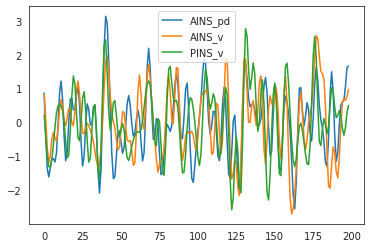

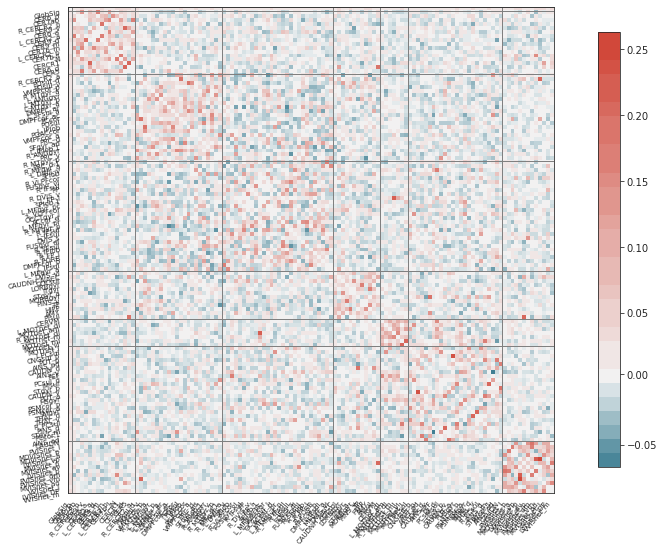

In [68]:
timeseries = []
perc_scrubbed = []
for i, f in enumerate(df['ts_file']):
    f = '..' + f.split('/..')[1]
    f_scrub = f.split('.tsv')[0] + '-scrubbed.tsv'

    ts = pd.read_csv(f_scrub).iloc[:, 1:]  # here we can omit global signal...

    fd_file = df["fd_file"].values[i]
    fd_file = '..' + fd_file.split('/..')[1]
    fd = pd.read_csv(fd_file).values.ravel().tolist()
    fd = [0] + fd

    perc_scrubbed.append(100 - 100 * len(ts.shape) / len(fd))
    timeseries.append(ts.values)

# double check visually
sub_idx = 10  # modify this for a different subject
# modify below for different regions (see the next cell for region names)
pd.DataFrame(timeseries[sub_idx], columns=ts.columns.values).loc[:, ['AINS_pd', 'AINS_v', 'PINS_v']].plot()
## Load region and module names for the MIST122 atlas
labels = ts.columns.values
l = pd.read_csv('../data/atlas_relabeled.tsv', sep="\t")
modules = np.insert(l['modules'].values, 0, "GlobSig")
print('Region names:\n', labels)
## Calculate functional connectivity as partial correlation
correlation_measure = ConnectivityMeasure(kind='partial correlation', vectorize=False)
X = correlation_measure.fit_transform(timeseries)  # these are the features
joblib.dump(X, "../res/multi-center/all_features.joblib")

# double-check the mean matrix visually
mat = correlation_measure.mean_
#mat=mat[1:, 1:] #fisrt row and column is global signal
mat[range(mat.shape[0]), range(mat.shape[0])] = 0  # zero diag
plot.plot_matrix(mat, labels, modules)

In [69]:
X.shape

(35, 123, 123)

# Load participant-level connectivity data

In [70]:
mc_model = pd.read_csv('../res/multi-center/finalized_model_connections.csv')
#mc_model = mc_model[mc_model['abs_multi-center']>0.02]
conns_mc_model = np.zeros((X.shape[0], len(mc_model)))
for idx, (i_a, i_b) in enumerate(zip(mc_model.idx_A, mc_model.idx_B)):
    #conns_mc_model(i_a, i_b)
    conns_mc_model[:, idx] = X[:, i_a, i_b]
conns_mc_model = pd.DataFrame(conns_mc_model, columns=mc_model.connectivity)
conns_mc_model

connectivity,GlobSig - VMPFcor_p,CER6_p - MORBgyr,CER6_p - PSMcor_p,CER7ab - CAUDNH_NACC,R_CERCR2_p - R_CERCR2_a,R_CERCR2_p - STgyr_a,R_CERCR2_p - AINS_v,R_CERCR2_p - PVISnet_dm,L_CERCR2_a - R_MTgyr_a,CER9_d - L_MFgyr_pc,...,MOTnet_m - MVISnet_p,MOTnet_m - LVISnet_p,PUT_p - STgyr_p,AINS_pd - PUT_a,AINS_pd - MDVISnet_p,AINS_v - MVISnet_ad,FEF - IMsul,STgyr_p - LVISnet_DP,THAL_d - PCcor.1,THAL_v - PINS_d
0,0.021891,0.124197,0.127759,-0.021352,0.145841,-0.064799,-0.006763,0.057262,-0.048813,-0.028449,...,0.081321,-0.046985,-0.016976,0.162298,0.075992,0.112617,-0.011008,-0.018719,-0.074869,-0.006091
1,0.015723,-0.128829,0.094542,0.125166,0.201690,-0.074666,0.017897,-0.086719,-0.122995,0.050970,...,0.033913,0.023110,-0.031482,-0.041393,0.042216,0.137049,-0.108424,-0.016450,-0.015471,0.032730
2,0.013114,-0.062290,-0.090155,0.052071,0.068738,0.030321,0.031548,0.089352,-0.032115,-0.026347,...,0.055872,-0.017286,0.022766,0.052997,-0.014386,0.104354,0.022060,0.069925,0.113806,-0.111940
3,0.020028,0.065334,-0.031791,0.147238,0.190687,0.042861,0.029229,0.056893,-0.048255,-0.086411,...,0.003797,0.066444,0.100155,0.101198,-0.015062,-0.022866,-0.129940,0.053899,-0.073163,0.060156
4,0.027947,-0.020950,-0.003799,0.133163,0.153021,-0.029537,0.018096,-0.028581,-0.038915,0.029342,...,0.057329,0.021621,-0.025921,-0.027753,0.061111,-0.010212,0.030001,-0.039720,-0.019237,0.064941
5,0.015798,0.008050,-0.031617,0.033865,0.193138,-0.008192,-0.043986,0.074691,-0.025664,0.102297,...,0.063765,-0.075995,0.019419,-0.062094,0.014223,0.025688,0.051473,0.075264,-0.045900,-0.047752
6,0.017596,0.115446,0.082807,-0.040199,0.222601,-0.013025,-0.022051,0.052107,0.028744,-0.081761,...,-0.067966,0.036262,0.051303,-0.018257,0.033269,-0.072007,0.002716,-0.060512,0.192386,0.006382
7,0.015496,0.184392,-0.014874,-0.009320,0.085708,0.054288,-0.063794,0.022744,-0.129352,-0.049156,...,0.007115,0.051090,-0.042815,0.127056,0.015604,0.032649,-0.092975,-0.098634,-0.118925,-0.070753
8,0.006319,0.007869,0.190031,-0.135721,0.192302,0.033759,0.002211,-0.113570,-0.026080,-0.056538,...,0.082103,0.001510,0.046489,0.035633,-0.032370,0.073592,-0.078871,0.005035,-0.104384,-0.004248
9,0.015954,0.102656,-0.130850,0.112110,0.139592,0.052967,-0.022115,0.006588,0.052858,-0.012350,...,-0.050317,-0.052372,-0.041581,-0.034095,-0.062451,-0.064845,0.003051,-0.011711,0.106824,-0.054249


In [71]:
#vars = df[['Male', 'Age', 'CDT_log_mean', 'WDT_log_mean', 'MDT_log_geom', 'CPT', 'HPT', 'MPT_log_geom', 't50', 'psq', 'pcs_catastrophizing', 'pcs_rumination', 'PSQI', 'anx_state', 'anx_trait', 'PSQ20', 'ads_k', 'Glx_mean', 'GABA_mean', 'meanFD', 'maxFD', 'medianFD', 'BP_MRI_sys', 'BP_MRI_dias', 'BP_QST_sys', 'BP_QST_dias' ]]
df2 = df.copy()
df2['nHPT'] = df.HPT * -1
df2['nMPT'] = df.MPT_log_geom * -1
df2['nt50'] = df.t50 * -1
df2['npsq'] = df.psq * -1
df2['nanx_state'] = df.anx_state * -1
df2['nanx_trait'] = df.anx_trait * -1

vars = df2[['CPT', 'nHPT', 'nMPT', 'nt50', 'npsq', 'nanx_state', 'nanx_trait', 'pcs_catastrophizing', 'pcs_rumination', 'PSQI', 'PSQ20', 'ads_k', 'Glx_mean', 'GABA_mean' ]]

vars.corrwith(df.mean_QST_pain_sensitivity)


CPT                    0.759185
nHPT                   0.807921
nMPT                   0.576325
nt50                   0.534950
npsq                  -0.123348
nanx_state            -0.141110
nanx_trait            -0.100309
pcs_catastrophizing    0.119169
pcs_rumination         0.215321
PSQI                        NaN
PSQ20                       NaN
ads_k                 -0.158223
Glx_mean               0.311628
GABA_mean              0.212076
dtype: float64

In [72]:
corrmtx = np.zeros((vars.shape[1], conns_mc_model.shape[1]))

for i in range(vars.shape[1]):
    for j in range(conns_mc_model.shape[1]):
        mask = ~np.isnan(vars.values[:,i]) & ~np.isnan(conns_mc_model.values[:,j])
        corrmtx[i, j] = np.corrcoef(vars.values[mask,i], conns_mc_model.values[mask,j])[0,1]
corrmtx = pd.DataFrame(corrmtx, columns=conns_mc_model.columns, index=vars.columns)
corrmtx

/home/tspisak/src/RPN-signature/venv/lib/python3.8/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/tspisak/src/RPN-signature/venv/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/home/tspisak/src/RPN-signature/venv/lib/python3.8/site-packages/numpy/lib/function_base.py:2683: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/home/tspisak/src/RPN-signature/venv/lib/python3.8/site-packages/numpy/lib/function_base.py:2542: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/home/tspisak/src/RPN-signature/venv/lib/python3.8/site-packages/numpy/lib/function_base.py:2542: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


connectivity,GlobSig - VMPFcor_p,CER6_p - MORBgyr,CER6_p - PSMcor_p,CER7ab - CAUDNH_NACC,R_CERCR2_p - R_CERCR2_a,R_CERCR2_p - STgyr_a,R_CERCR2_p - AINS_v,R_CERCR2_p - PVISnet_dm,L_CERCR2_a - R_MTgyr_a,CER9_d - L_MFgyr_pc,...,MOTnet_m - MVISnet_p,MOTnet_m - LVISnet_p,PUT_p - STgyr_p,AINS_pd - PUT_a,AINS_pd - MDVISnet_p,AINS_v - MVISnet_ad,FEF - IMsul,STgyr_p - LVISnet_DP,THAL_d - PCcor.1,THAL_v - PINS_d
CPT,0.333312,0.374806,-0.399343,0.375241,0.151132,-0.130079,-0.100615,0.195789,-0.070447,0.155257,...,-0.419465,0.189025,0.386849,-0.141544,-0.144565,-0.461459,0.188071,0.218088,0.208331,0.269760
nHPT,-0.013280,0.077984,-0.538341,0.335189,0.167214,-0.256030,-0.271959,0.140913,-0.072894,0.409838,...,-0.306366,0.190113,0.470782,-0.181446,-0.384373,-0.516359,0.349834,0.383546,0.341867,0.029936
nMPT,-0.017185,-0.030819,-0.150040,0.112165,-0.064833,-0.065997,-0.092355,-0.240960,0.039434,0.210343,...,-0.373705,0.325024,0.363205,-0.268084,-0.172364,-0.251472,0.144575,0.157310,0.308723,0.205089
nt50,0.009989,0.180914,-0.319194,0.069174,0.084996,0.015976,-0.153033,0.072413,-0.007896,-0.018929,...,-0.453834,0.408920,0.224664,0.078798,-0.138484,-0.324741,0.107535,-0.082198,0.286457,0.286114
npsq,0.039154,0.109750,0.095093,0.065729,-0.226630,-0.076855,0.157944,-0.105427,0.141701,-0.155221,...,0.161762,-0.059896,-0.282032,-0.065319,0.244607,0.328346,0.025535,0.071569,-0.326893,-0.045007
nanx_state,0.098386,0.055703,0.225944,-0.153732,-0.053126,0.122675,0.078726,0.065378,0.221956,-0.276056,...,0.486521,0.071355,-0.066952,0.283192,0.020867,-0.075881,-0.089876,-0.075110,-0.198835,0.009739
nanx_trait,-0.105289,-0.306623,-0.087606,-0.226740,-0.311312,0.180302,-0.108714,0.128168,-0.158515,-0.252334,...,-0.145036,0.097296,-0.035385,0.033113,-0.240059,0.140403,0.012096,0.224082,0.015635,0.041936
pcs_catastrophizing,0.199020,0.070742,-0.064475,0.083346,-0.019881,-0.119486,0.088551,0.278404,-0.424090,0.115329,...,0.247052,-0.048715,0.103588,0.201039,-0.038496,-0.033114,0.251745,0.030508,0.057661,0.071985
pcs_rumination,0.159344,0.100928,-0.025577,-0.138164,0.101819,-0.262166,-0.017303,0.229777,-0.308559,0.308589,...,0.105289,-0.075319,0.031824,0.159639,-0.137901,-0.249635,0.316611,-0.046288,0.109181,0.025208
PSQI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:ylabel='connectivity'>

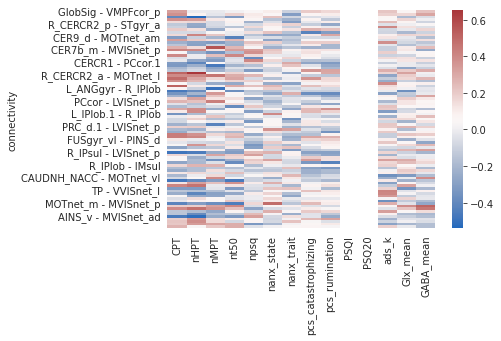

In [73]:
sns.heatmap(corrmtx.T, cmap=sns.color_palette("vlag", as_cmap=True))

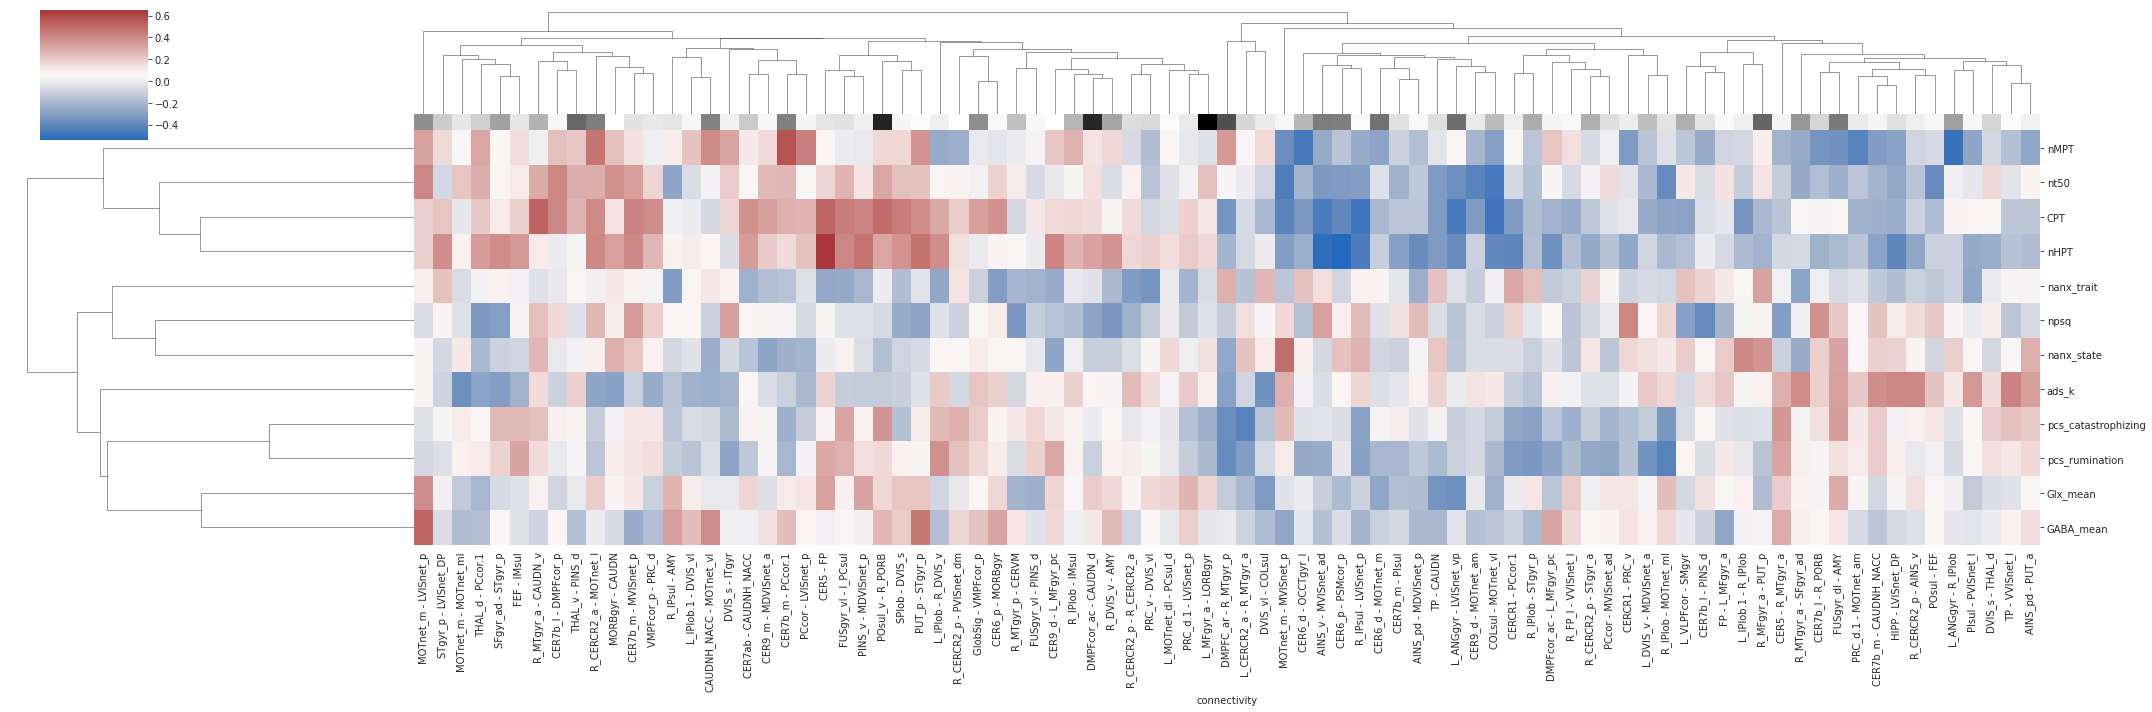

In [74]:
norm = Normalize()
sns.clustermap(corrmtx.dropna(), cmap="vlag", figsize=(30,10), col_colors=cm.binary(norm(mc_model['abs_multi-center'])))

In [75]:
#Importing libraries
from sklearn.datasets import load_iris
from sklearn.cluster import AgglomerativeClustering
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram , linkage

In [76]:
#Linkage Matrix
Z = linkage(corrmtx.T, method = 'ward')
#plotting dendrogram
plt.figure(figsize=(20,10))
dendro = dendrogram(Z, labels=corrmtx.columns)
plt.title('Dendrogram')
plt.ylabel('Euclidean distance')
plt.xticks(fontsize = 12)
plt.show()


ValueError: The condensed distance matrix must contain only finite values.

In [ ]:
Z=pd.DataFrame(Z, index=corrmtx.columns)

In [ ]:
corrmtx.shape

In [ ]:
Z